In [1]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
from cv2 import resize
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Create Files_Name
image_data=r"C:\Users\HP\Downloads\archive (1)\Faulty_solar_panel"
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Bird-drop
1,Clean
2,Dusty
3,Electrical-damage
4,Physical-Damage
5,Snow-Covered


In [3]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\HP\Downloads\archive (1)\Faulty_solar_panel",
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\HP\Downloads\archive (1)\Faulty_solar_panel",
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


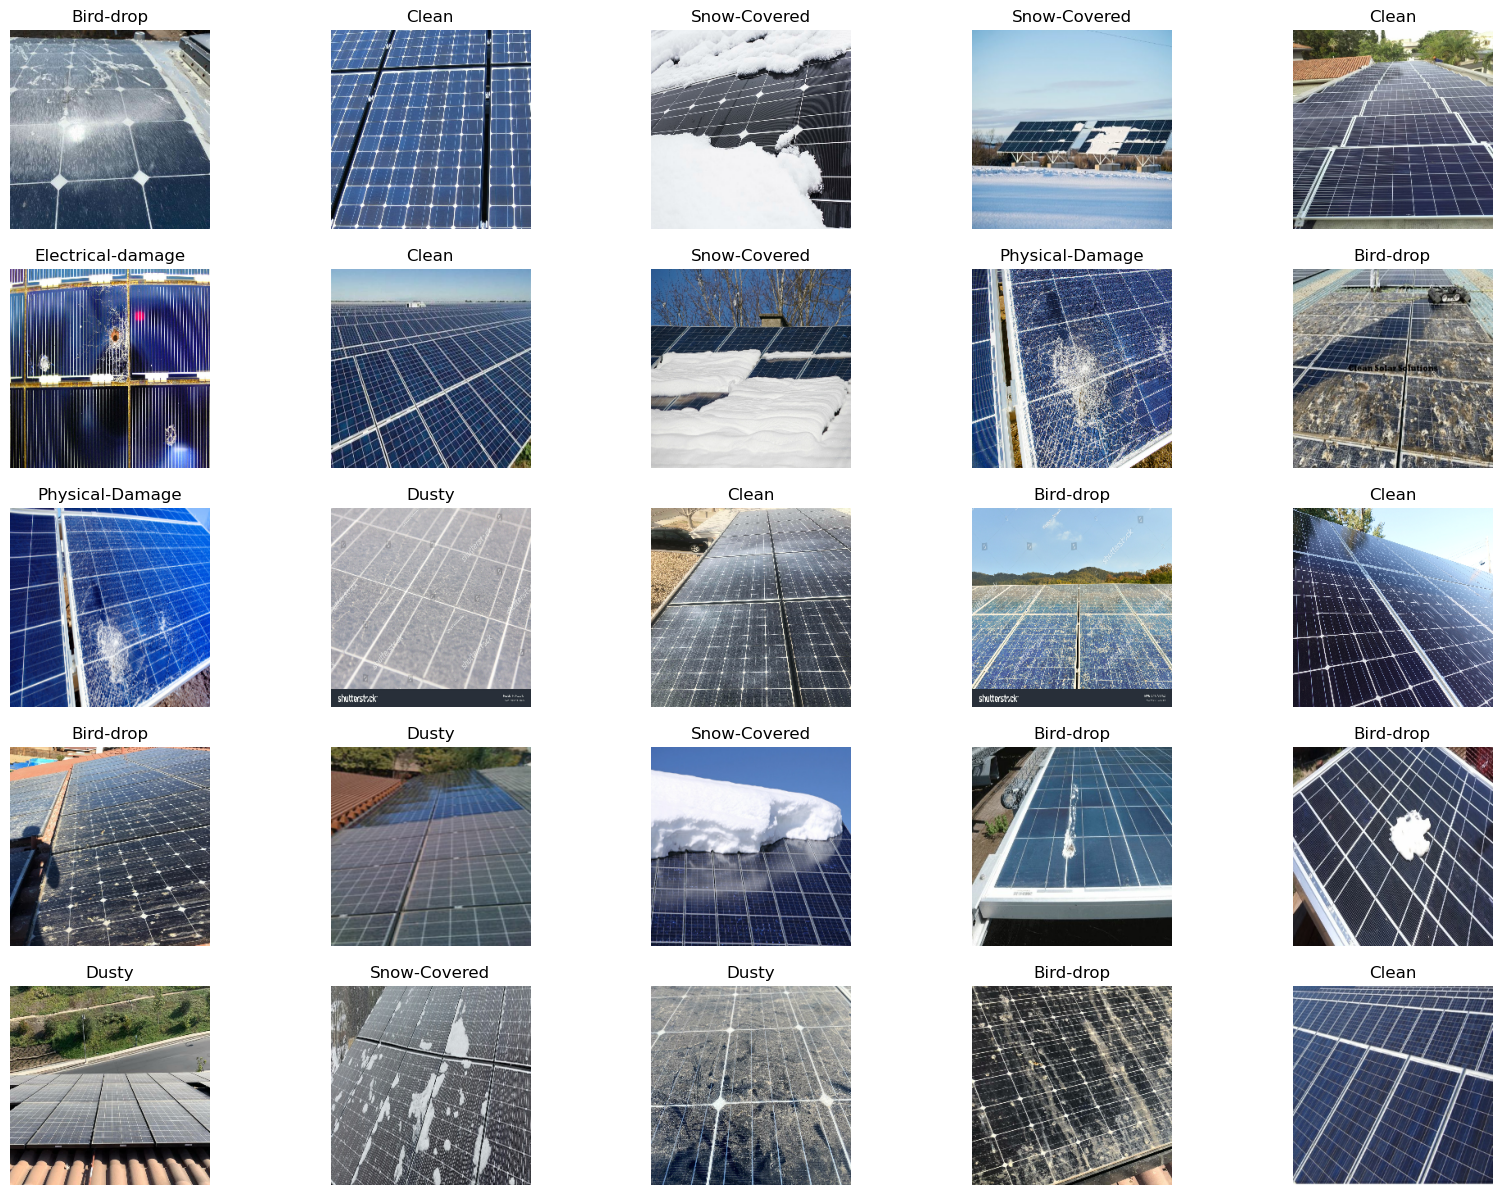

In [5]:
plt.figure(figsize=(20, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

In [7]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 244, 244, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 244, 244)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 244, 244)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 244, 244)          │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 244, 244, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 244, 244, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 7, 7, 512)         │      20,024,384 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 512)               │               0 │ vgg19[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 90)                │          46,170 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,070,554 (76.56 MB)

 Trainable params: 46,170 (180.35 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
import tensorflow as tf  # Assuming you're using TensorFlow

from tensorflow.keras.utils import plot_model

# Assuming you have your Keras model defined as 'model'

plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer_1      │ (None, 244, 244, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ get_item (GetItem) │ (None, 244, 244) │         0 │ input_layer_1[0… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ get_item_1         │ (None, 244, 244) │         0 │ input_layer_1[0… │
│ (GetItem)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ get_item_2         │ (None, 244, 244) │         0 │ input_layer_1[0… │
│ (GetItem)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stack (Stack)      │ (None, 244, 244, │         0 │ get_item[0][0],  │
│                    │ 3)               │           │ get_item_1[0][0… │
│                    │                  │           │ get_item_2[0][0] │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ add (Add)          │ (None, 244, 244, │         0 │ stack[0][0]      │
│                    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ vgg19 (Functional) │ (None, 7, 7,     │ 20,024,3… │ add[0][0]        │
│                    │ 512)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ global_average_po… │ (None, 512)      │         0 │ vgg19[0][0]      │
│ (GlobalAveragePoo… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dropout (Dropout)  │ (None, 512)      │         0 │ global_average_… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dense (Dense)      │ (None, 90)       │    46,170 │ dropout[0][0]    │
└────────────────────┴──────────────────┴───────────┴──────────────────┘

 Total params: 20,070,554 (76.56 MB)

 Trainable params: 14,205,018 (54.19 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
%%time

epoch = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.2170 - loss: 5.0736 - val_accuracy: 0.6441 - val_loss: 1.2070
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - accuracy: 0.6116 - loss: 1.1825 - val_accuracy: 0.7119 - val_loss: 0.7358
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.8039 - loss: 0.6324 - val_accuracy: 0.7288 - val_loss: 0.7346
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.8654 - loss: 0.4217 - val_accuracy: 0.7797 - val_loss: 0.6637
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.8774 - loss: 0.3422 - val_accuracy: 0.8192 - val_loss: 0.7089
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.9666 - loss: 0.1320 - val_accuracy: 0.8814 - val_loss: 0.5136
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.9592 - loss: 0.1118 - val_accuracy: 0.8418 - val_loss: 0.6729
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.9718 - loss: 0.0849 - val_accuracy: 0.8192 - v

In [13]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.330508,3.090915,0.644068,1.207039
1,0.634181,1.134028,0.711864,0.735788
2,0.820621,0.594765,0.728814,0.734615
3,0.877119,0.377503,0.779661,0.663693
4,0.887006,0.344130,0.819209,0.708870
5,0.960452,0.140857,0.881356,0.513640
6,0.966102,0.094496,0.841808,0.672932
7,0.973164,0.088289,0.819209,0.657605
8,0.964689,0.119493,0.694915,1.876769


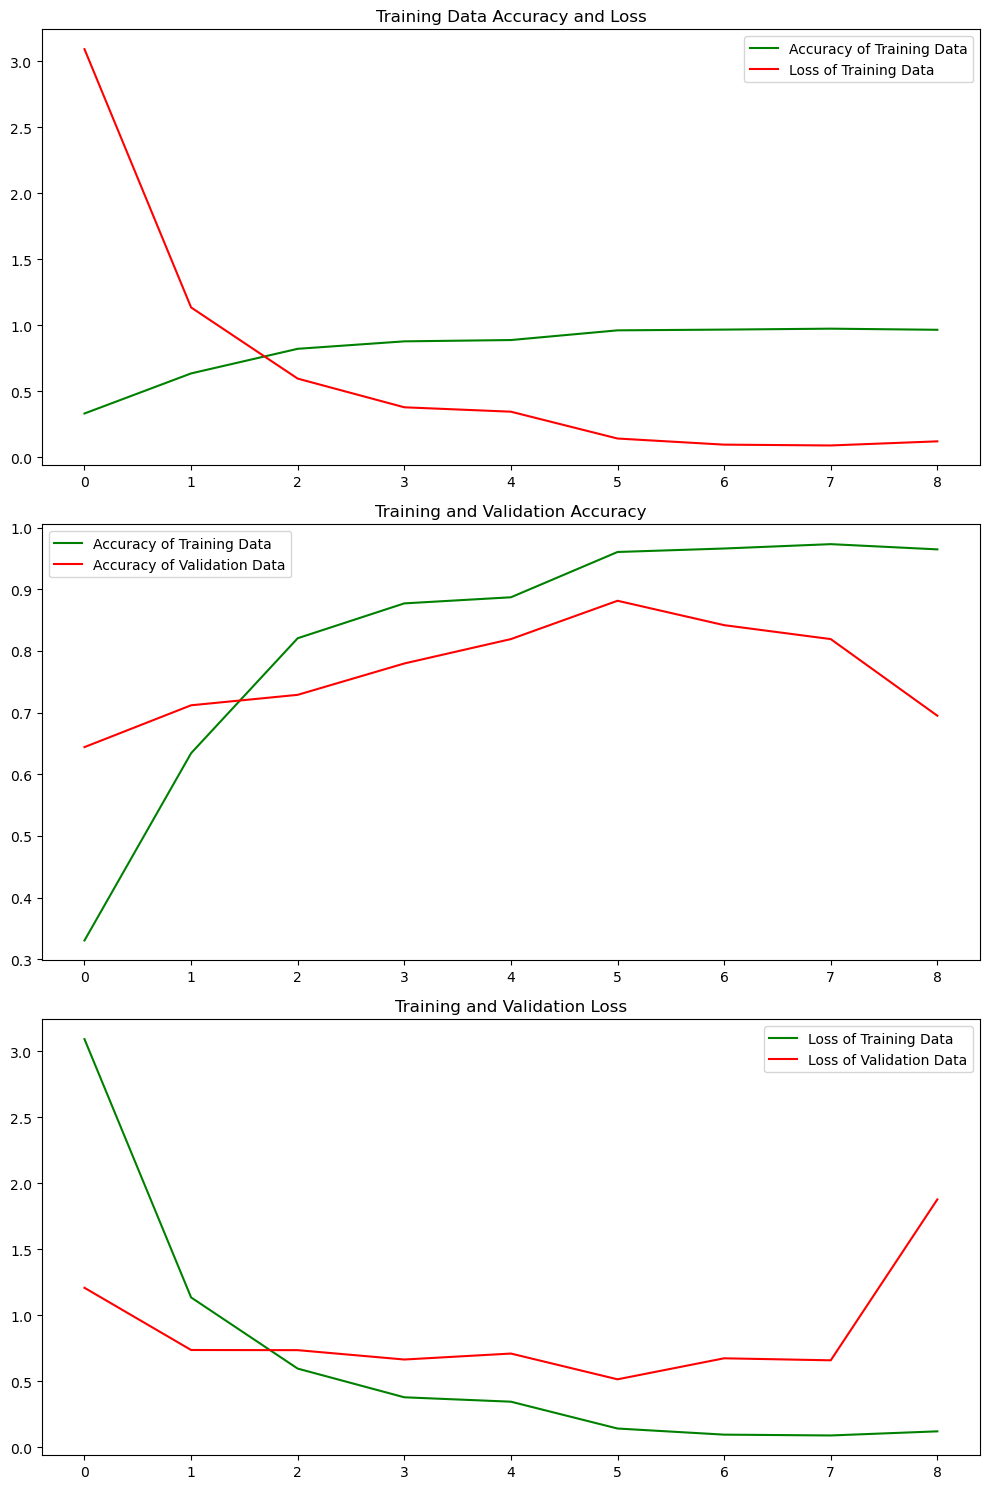

In [14]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))

# Create a figure with 3 subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))  # Adjust figsize as needed

# Plot training accuracy and loss
ax1.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
ax1.plot(epochs, get_los, 'r', label='Loss of Training Data')
ax1.set_title('Training Data Accuracy and Loss')
ax1.legend(loc=0)

# Plot training and validation accuracy
ax2.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
ax2.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc=0)

# Plot training and validation loss
ax3.plot(epochs, get_los, 'g', label='Loss of Training Data')
ax3.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
ax3.set_title('Training and Validation Loss')
ax3.legend(loc=0)

# Adjust spacing between subplots (optional)
plt.tight_layout()

plt.show()

In [15]:
X_val,y_val,y_pred=[],[],[]
for images, labels in val_ds:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


,Actual,Prediction
0,4,3
1,1,1
2,1,1
3,4,4
4,2,5
...,...,...
172,1,1
173,2,5
174,0,0
175,5,5
